# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.mode as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 
# For searching in the string 
CC = 'CC'
MLO = 'MLO'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
WEIGHTS = '/home/kazzastic/Videos/Breast-Cancer-Lump-Segmentation-MaskRCNN/training'
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(WEIGHTS, "mask_rcnn_balloon.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


## Configurations

In [2]:
class BreastTumorsConfig(Config):
    """Configuration for training on the toy tumors dataset.
    Derives from the base Config class and overrides values specific
    to the toy tumors dataset.
    """
    # Give the configuration a recognizable name
    NAME = "roi_breast_tumors_patches1024_NR"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    #NUM_CLASSES = 1 + 3  # background + 3 shapes
    # How many tumor shapes do we have?
    NUM_CLASSES = 1 + 3  # background + tumors|

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 2831
    #STEPS_PER_EPOCH = 2205
    #STEPS_PER_EPOCH = 220

    # use small validation steps since the epoch is small
    VALIDATION_STPES = 626
    #VALIDATION_STPES = 63
    
    USE_MINI_MASK=False
    
config = BreastTumorsConfig()
#config.print()

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [67]:
import skimage.color

class BreastTumorsDataset(utils.Dataset):
    
    def load_dataset(self, class_file1, image_dir1, mask_dir1, class_file2=None, image_dir2=None, mask_dir2=None):
        """
        Initialize the dataset with the images from dataset_dir folder.
        """
        
        # Add classes
        self.df_class1 = pd.read_csv(class_file1)
        
        
        self.add_class("bt_shapes", 1, 'NORMAL')
        self.add_class("bt_shapes", 2, 'BENIGN')
        self.add_class("bt_shapes", 3, 'MALIGNANT')
        
        for root, dirs, files in os.walk(image_dir1):
            for filename in files:
                self.add_image(
                    source='bt_shapes',
                    image_id=filename,
                    path=os.path.join(image_dir1, filename)
                )        
        
        self.mask_dir1 = mask_dir1

        if class_file2 != None:
            self.df_class2 = pd.read_csv(class_file2)
        
        if image_dir2 != None:
            for root, dirs, files in os.walk(image_dir2):
                for filename in files:
                    self.add_image(
                        source='bt_shapes',
                        image_id=filename,
                        path=os.path.join(image_dir2, filename)
                    )        
                
        self.mask_dir2 = mask_dir2
        
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        #print(self.image_info[image_id]['path'])
        image = cv2.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            image = skimage.color.gray2rgb(image)
        return image

    def load_mask(self, image_id):
        """Load masks for the given image ID.
        """
        imagepath = self.image_info[image_id]['path']
        
        image_dir, imagefile = os.path.split(imagepath)
        imagefilename, ext = os.path.splitext(imagefile)
        another = imagefilename
        var = imagefilename
        #print("Imagefile:{}".format(var))
        if(CC in var):
            var, _ = var.split('CC')
            var+='CC'
        elif(MLO in var):
            var, _ = var.split('MLO')
            var+='MLO'
        else:
            pass
            
        temp = var
        var_4_pathology = var
        #print("Imagefile But Better:{}".format(temp))
        prefix, patient_id1, patient_id2, side, viewsuffix = temp.split('_')
        #view, abn, angle, patch_width, patch_height, hstride, vstride, row, column, pathology = viewsuffix.split('-')
        #patient_id = patient_id1 + '_' + patient_id2        
        #abn_num = abn[1:]
        #maskfile = prefix + '_' + \
        #            patient_id + '_' + \
        #            side + '_' + \
        #            view + '_' + \
        #            abn_num + '_' + \
        #            'mask' + '-' + \
        #            abn + '-' + \
        #            angle + '-' + \
        #            patch_width + '-' + \
        #            patch_height + '-' + \
        #            hstride + '-' + \
        #            vstride + '-' + \
        #            row + '-' + \
        #            column + '-' + \
        #            pathology + ext
        
        #maskfile = os.path.join(self.mask_dir1,prefix+'_'+patient_id1+'_'+patient_id2+'_'+side+'_'+viewsuffix+'_mask.png')
        if(prefix=='Calc-Test' or prefix=='Mass-Test'):
            csv = pd.read_csv('/home/kazzastic/Videos/csv/calc_case_description_test_set.csv')
            maskfile = csv[csv['image file path'].str.contains(temp)]
            maskfile = maskfile['ROI mask file path'].to_frame().iloc[0][0].split('/')
            maskfile[0]+='_mask.png'
            #print("Maskfile:{}".format(maskfile[0]))
        else:
            csv = pd.read_csv('/home/kazzastic/Videos/csv/calc_case_description_train_set.csv')
            maskfile = csv[csv['image file path'].str.contains(temp)]
            maskfile = maskfile['ROI mask file path'].to_frame().iloc[0][0].split('/')
            maskfile[0]+='_mask.png'
            #print("Maskfile:{}".format(maskfile[0]))
        # Load mask
        if(prefix == 'Calc-Test' or prefix=='Mass-Test'):
            path_for_mask = '/media/kazzastic/C08EBCFB8EBCEAD4/ROI_sorted/calc-test/'
            #mask = cv2.imread(path_for_mask+maskfile[0])
            full_path = path_for_mask+maskfile[0]
            print("This is full Path "+full_path)
            mask = cv2.imread(full_path)
        else:
            path_for_mask = '/media/kazzastic/C08EBCFB8EBCEAD4/ROI_sorted/calc-train/'
            #mask = cv2.imread(path_for_mask+maskfile[0])
            full_path = path_for_mask+maskfile[0]
            #print("This is full Path "+full_path)
            mask = cv2.imread(full_path)
        # If grayscale. Convert to RGB for consistency.
        #if mask.ndim != 3:
        #    mask = skimage.color.gray2rgb(mask)
        pathology = csv[csv['image file path'].str.contains(var_4_pathology)]
        pathology = pathology['pathology'].to_frame().iloc[0][0]
        
        # If grayscale. Convert to RGB for consistency.
        #print("mask: ", mask)
        if mask.ndim != 3:
            mask = skimage.color.gray2rgb(mask)
        
        # Map class names to class IDs.
        if pathology == 'MALIGNANT':
            class_ids = np.array([3, 3, 3])
        else:
            class_ids = np.array([2, 2, 2])

        return mask, class_ids.astype(np.int32)
    
    
    def image_reference(self, image_id):
        """Return a link to the images in the folder"""
        info = self.image_info[image_id]
        if info["source"] == "bt_shapes":
            return self.image_info[image_id]['path']
        else:
            super(self.__class__).image_reference(self, image_id)

## Create Model

In [68]:

#Validation dataset
dataset_val = BreastTumorsDataset()

dataset_val.load_dataset(class_file1=os.path.join('/home/kazzastic/Videos/csv', 'calc_case_description_train_set.csv'), \
                          image_dir1=os.path.join('/media/kazzastic/C08EBCFB8EBCEAD4/Mammogram_sorted', 'calc-train'), \
                          mask_dir1=os.path.join('/media/kazzastic/C08EBCFB8EBCEAD4/ROI_sorted', 'calc-train'))


dataset_val.prepare()
dataset_val.image_ids

array([   0,    1,    2, ..., 1221, 1222, 1223])

## Detection

In [65]:
class InferenceConfig(BreastTumorsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
MY_MODEL = '/home/kazzastic/Videos/Breast-Cancer-Lump-Segmentation-MaskRCNN/training/logs'
model_path = os.path.join(MY_MODEL,'Model1.h5')

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/kazzastic/Videos/Breast-Cancer-Lump-Segmentation-MaskRCNN/training/logs/Model1.h5


Image id: 100

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.22861051559448242 seconds
Image id: 101

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.18965744972229004 seconds
Image id: 


Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1844644546508789 seconds
Image id: 118

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19162869453430176 seconds
Image id: 119

Processing

/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1989119052886963 seconds
Image id: 121

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



*** No instances to display *** 

Detection time = 0.18985414505004883 seconds
Image id: 122

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



*** No instances to display *** 

Detection time = 0.19200706481933594 seconds
Image id: 123

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app


molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19586491584777832 seconds
Image id: 124


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.17978549003601074 seconds
Image id: 125


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1855173110961914 seconds
Image id: 126


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19119977951049805 seconds
Image id: 127


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1902296543121338 seconds
Image id: 128


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.18019509315490723 seconds
Image id: 129


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.18084311485290527 seconds
Image id: 130


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  238.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  134.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.17860984802246094 seconds
Image id: 131


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1936943531036377 seconds
Image id: 132


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  214.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  110.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.17899060249328613 seconds
Image id: 133


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  232.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  128.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19473886489868164 seconds
Image id: 134


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.18375635147094727 seconds
Image id: 135


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19312310218811035 seconds
Image id: 136


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.18889451026916504 seconds
Image id: 137


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  250.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19265151023864746 seconds
Image id: 138


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19146943092346191 seconds
Image id: 139


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19321012496948242 seconds
Image id: 140


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1798088550567627 seconds
Image id: 141


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19834136962890625 seconds
Image id: 142


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19727063179016113 seconds
Image id: 143


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1860980987548828 seconds
Image id: 144


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19524455070495605 seconds
Image id: 145


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  228.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  124.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.1914207935333252 seconds
Image id: 146


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19088244438171387 seconds
Image id: 147


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19295191764831543 seconds
Image id: 148


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.19176983833312988 seconds
Image id: 149


/home/kazzastic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app



Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 

Detection time = 0.17868661880493164 seconds


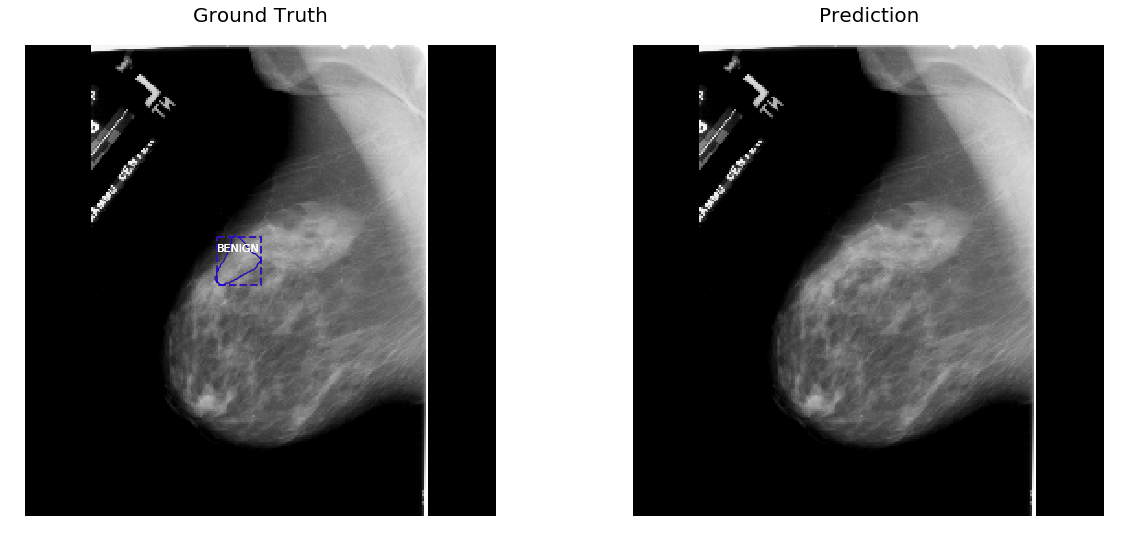

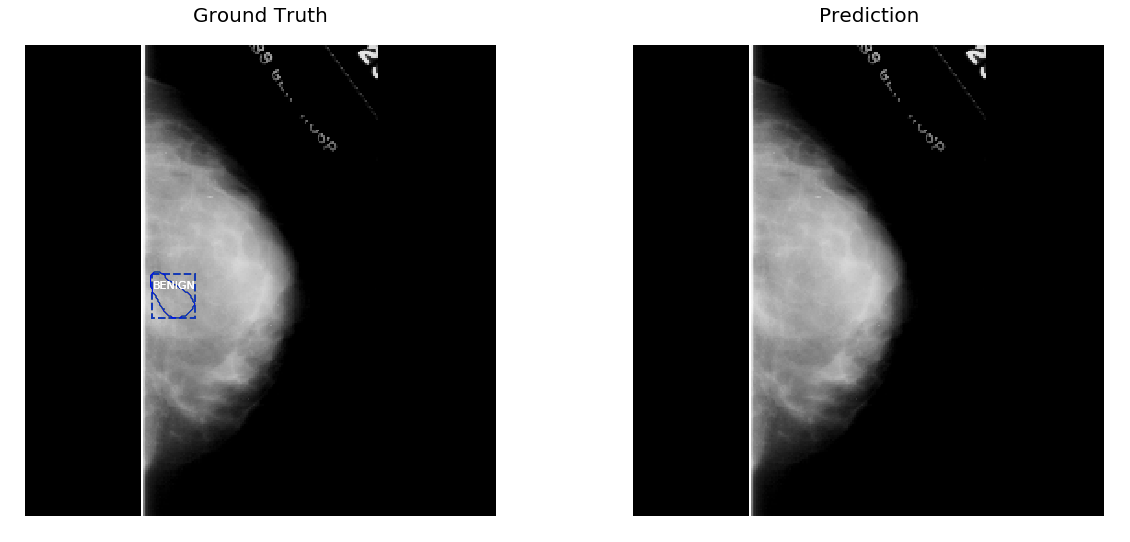

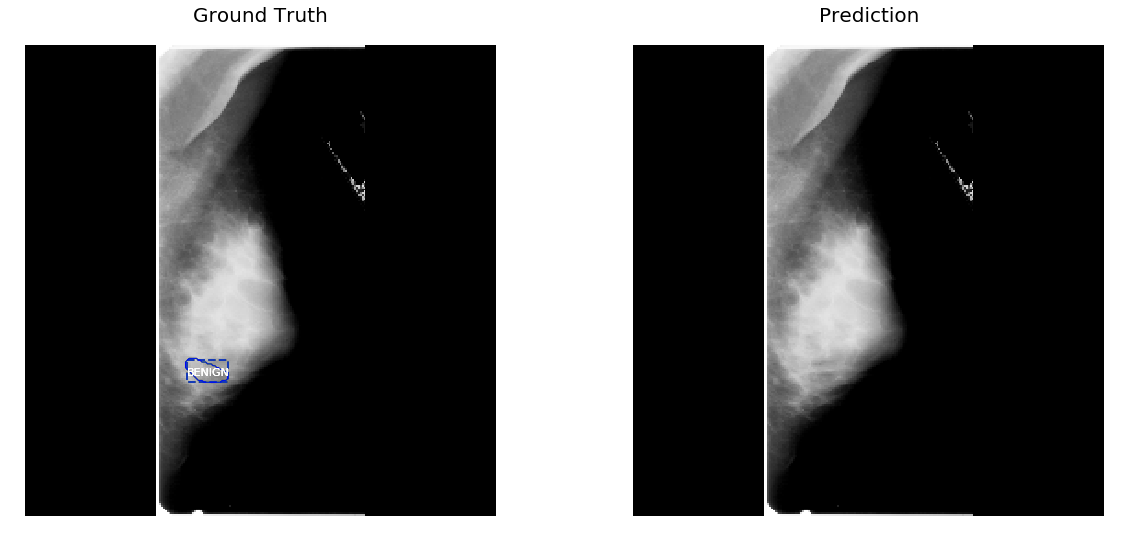

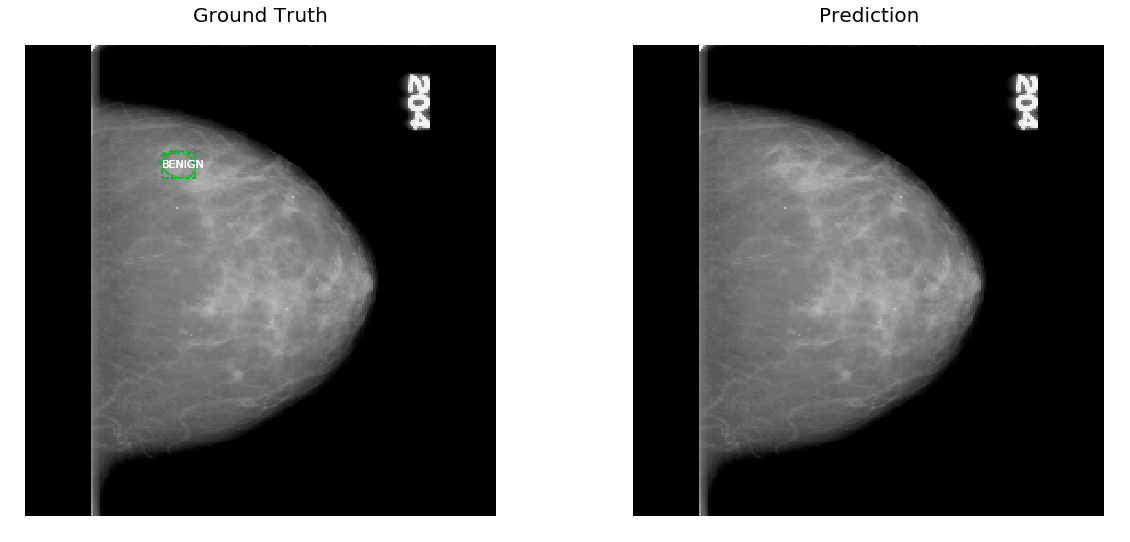

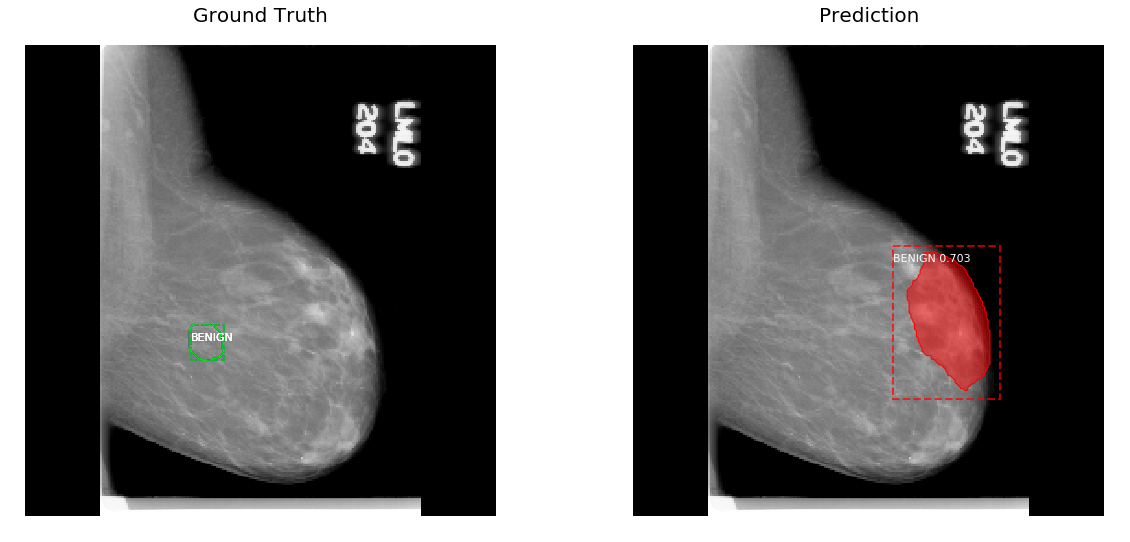

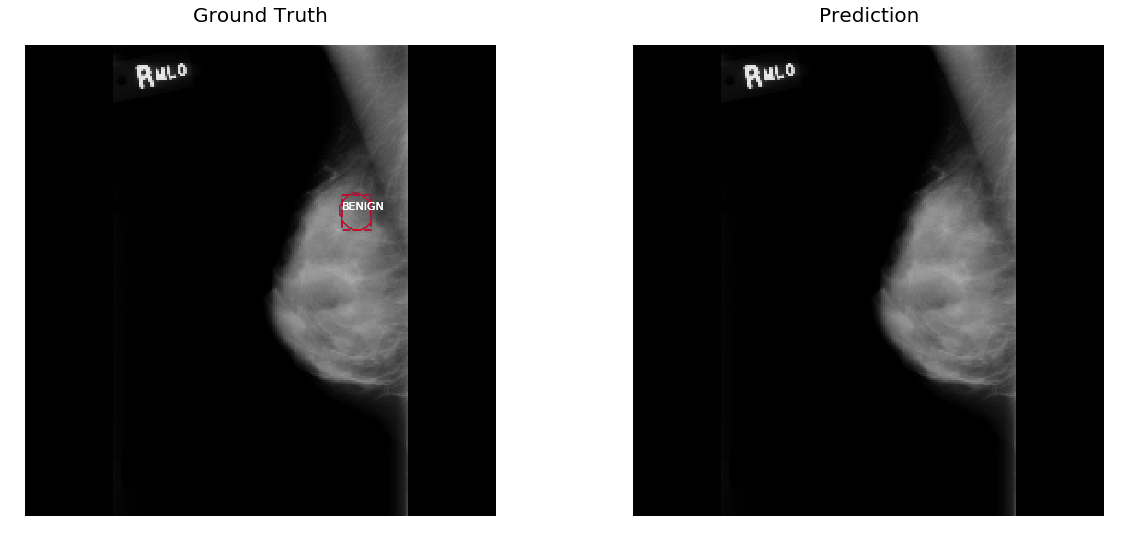

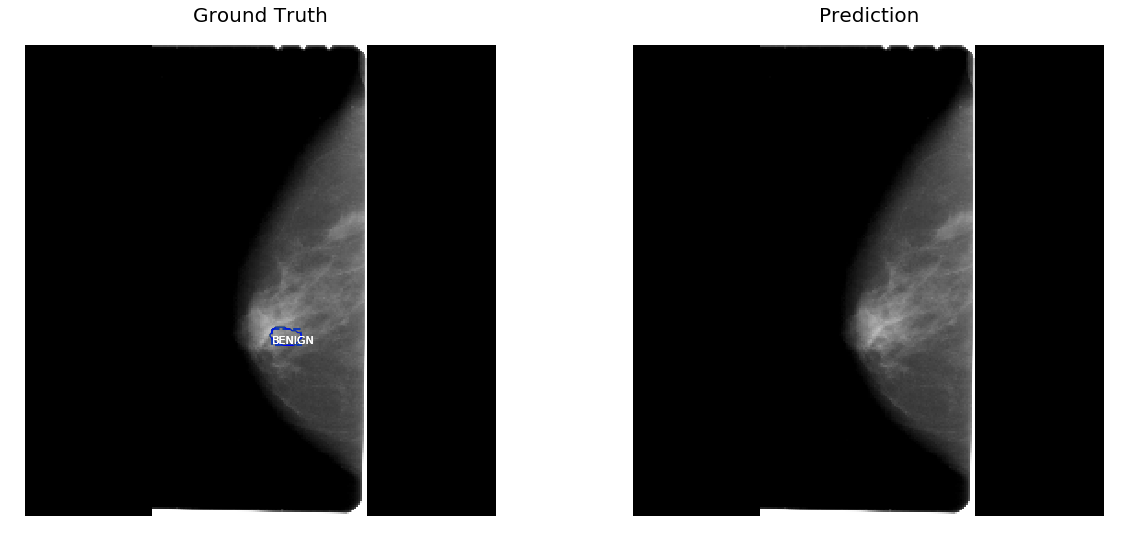

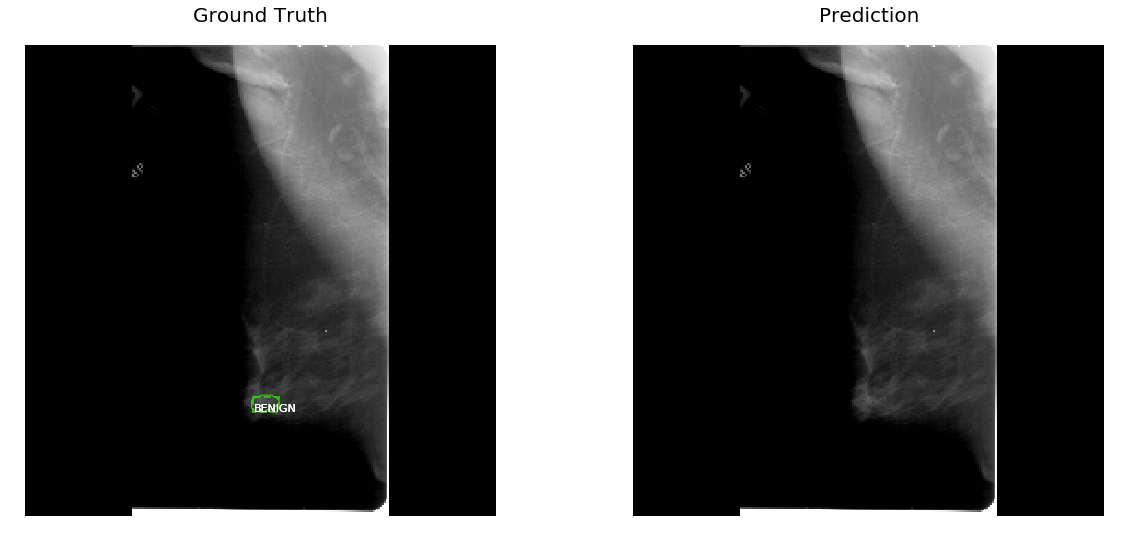

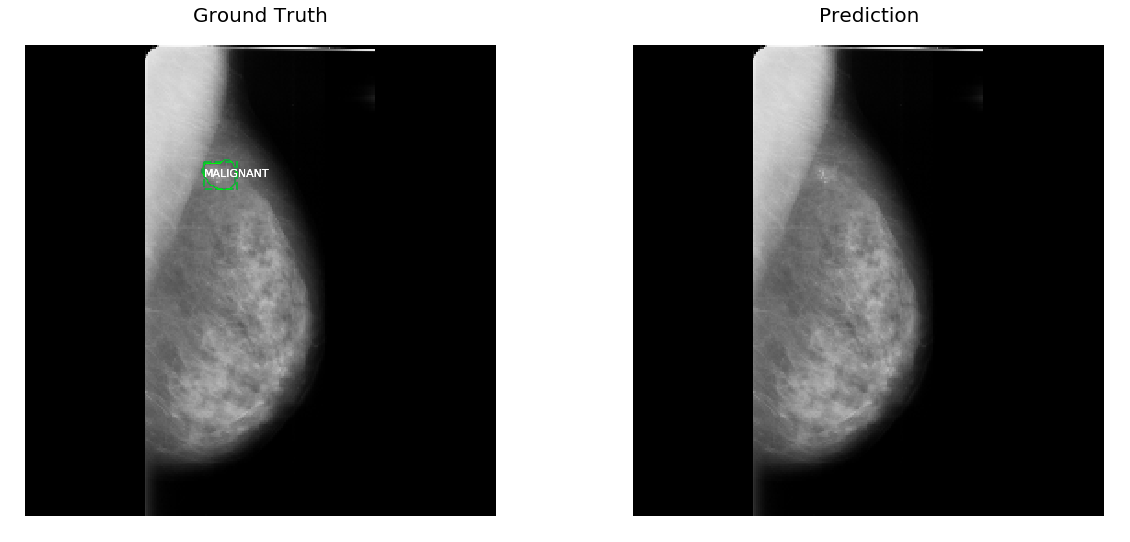

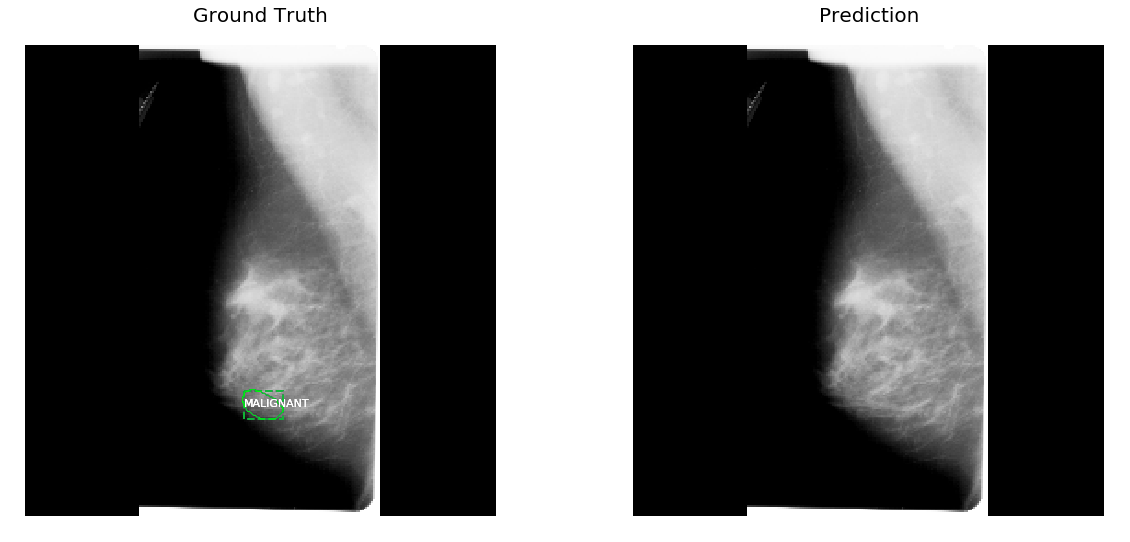

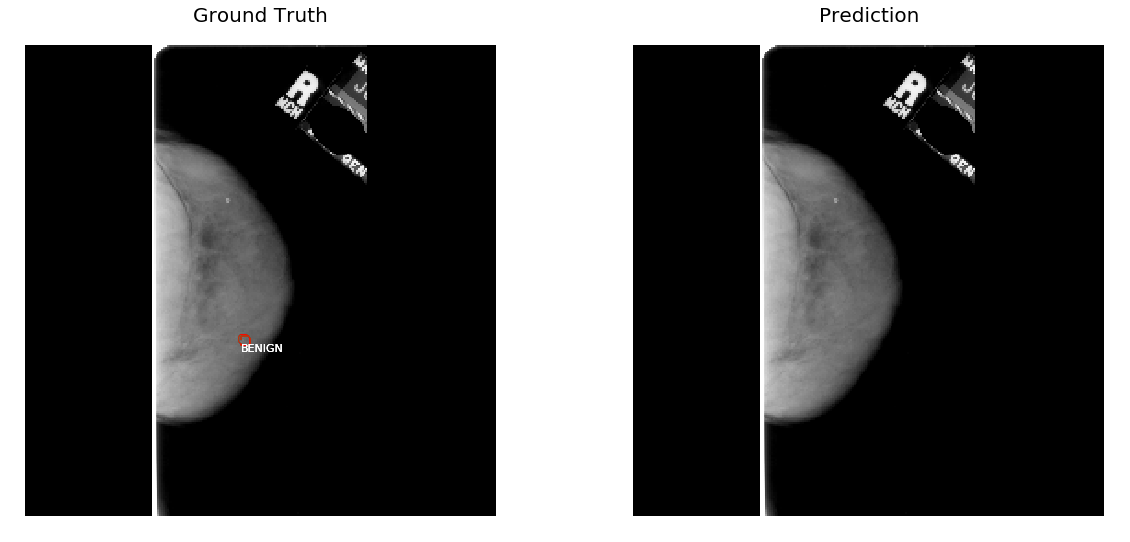

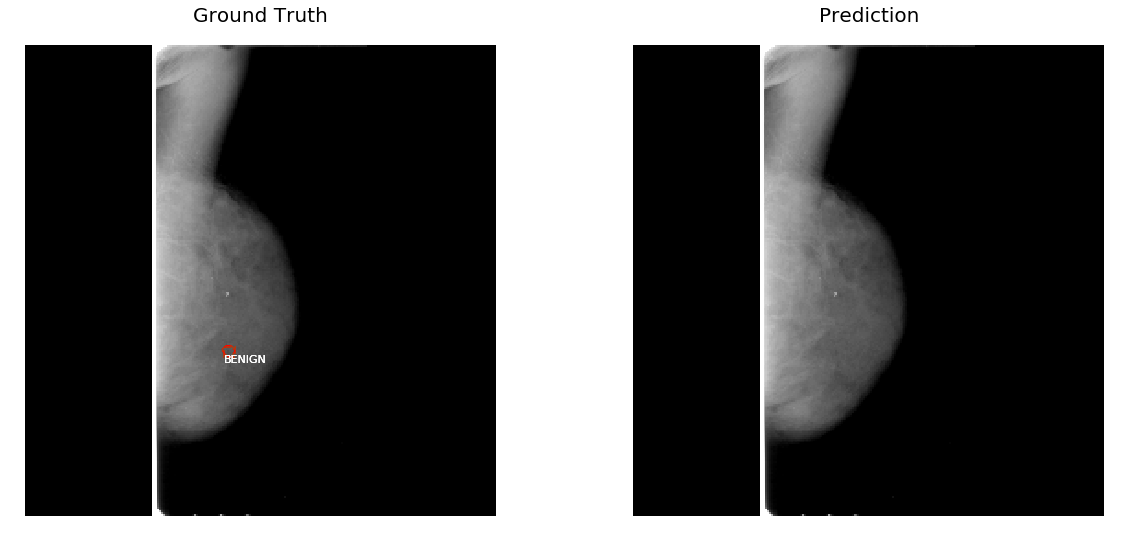

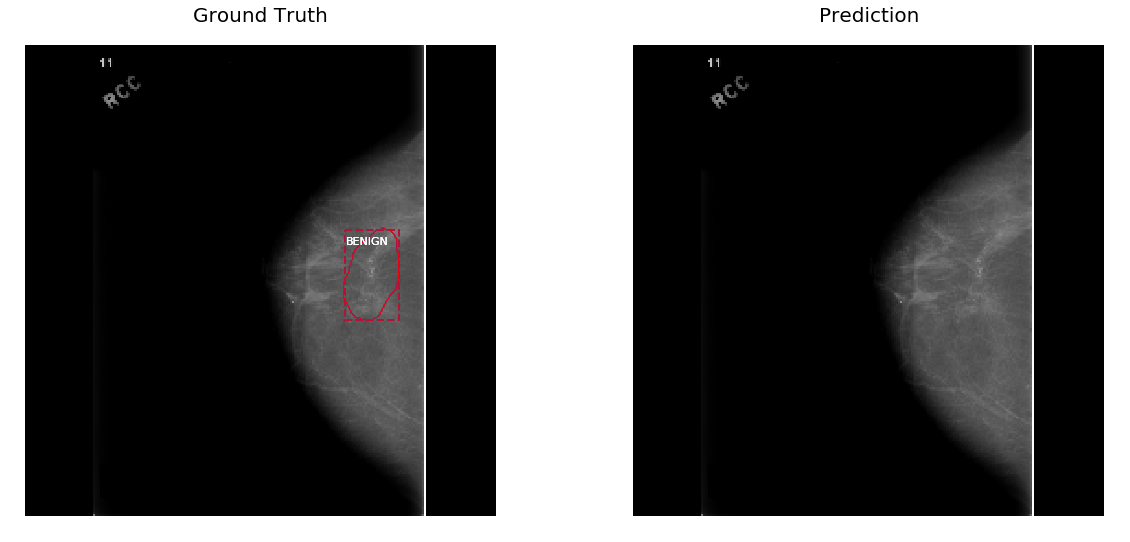

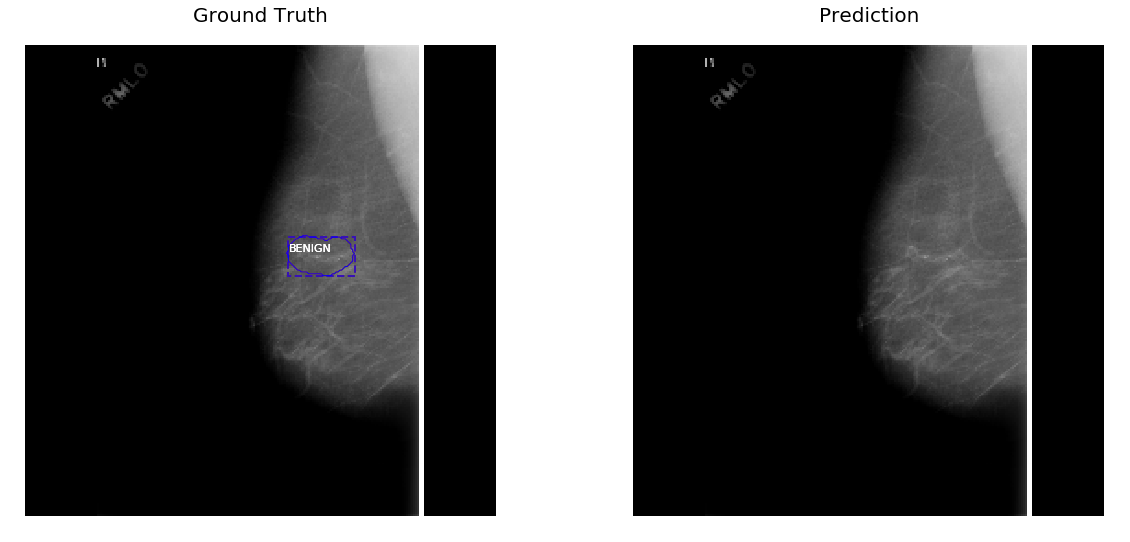

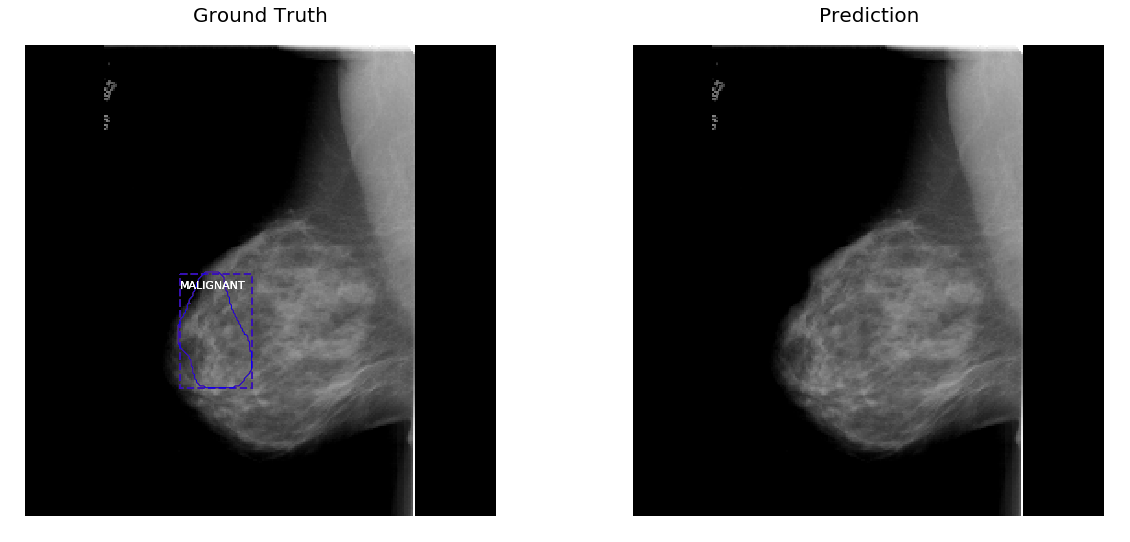

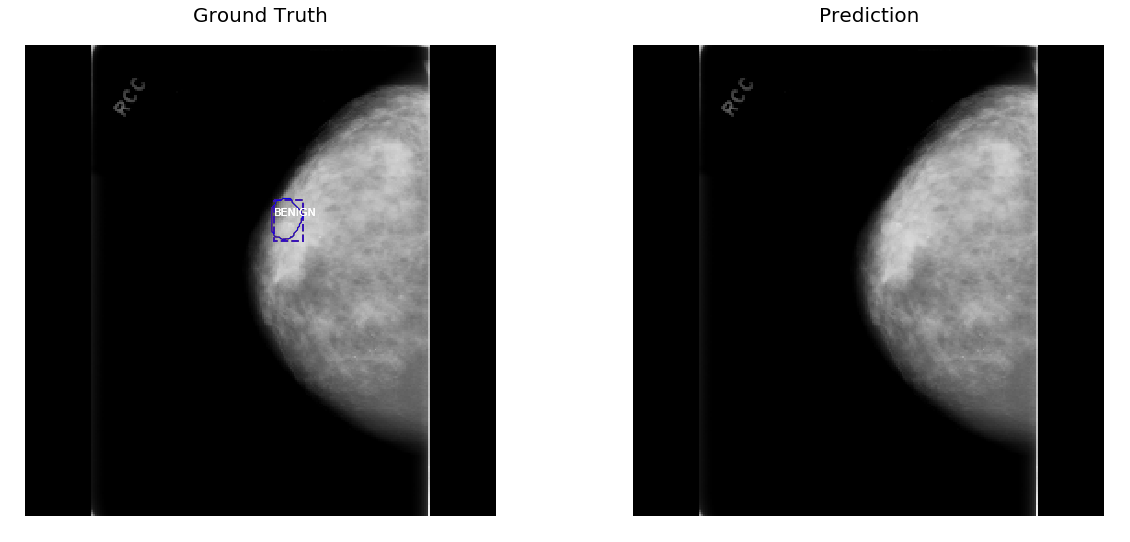

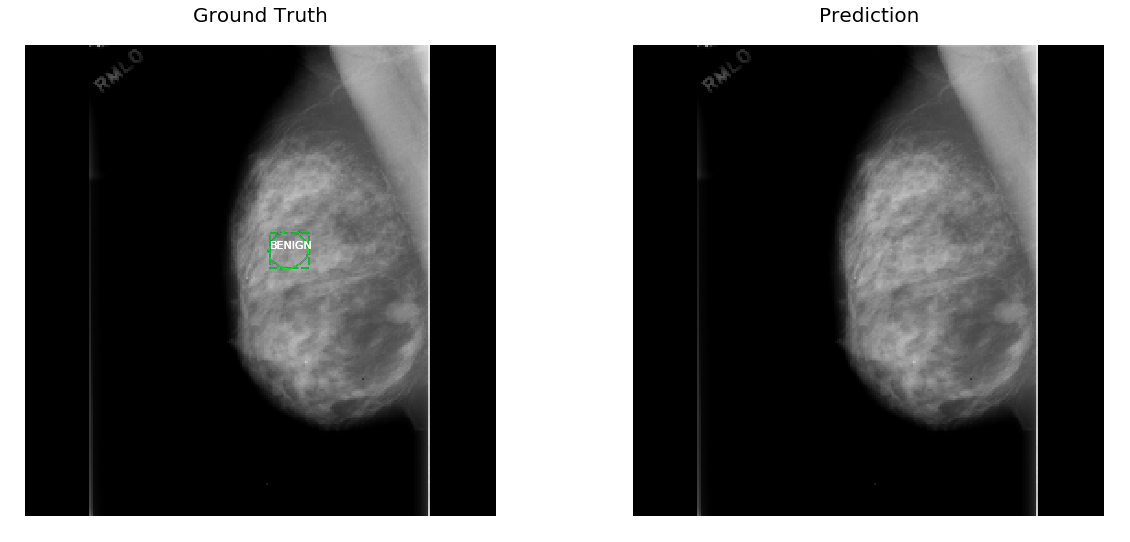

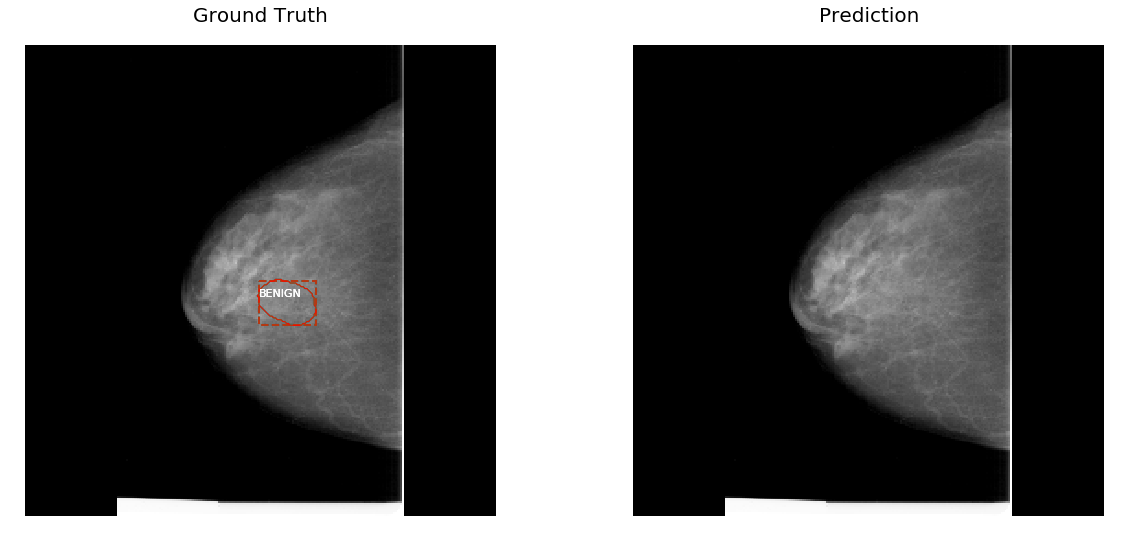

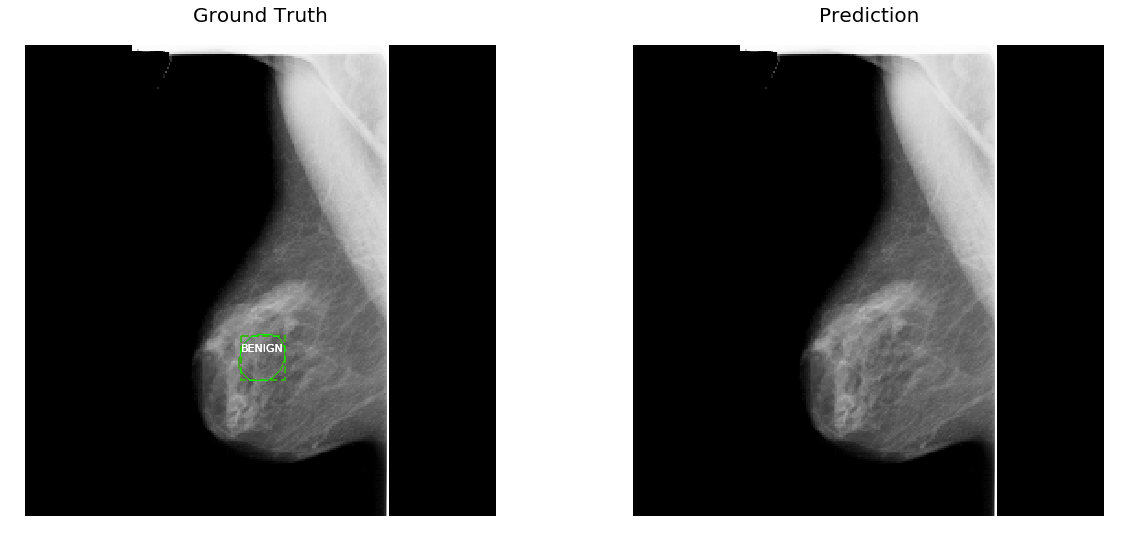

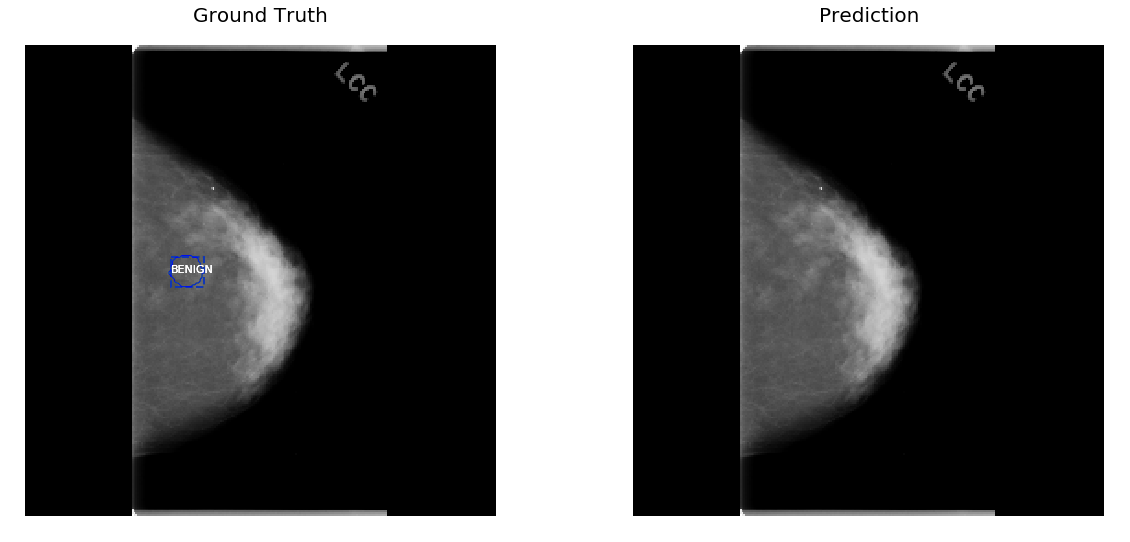

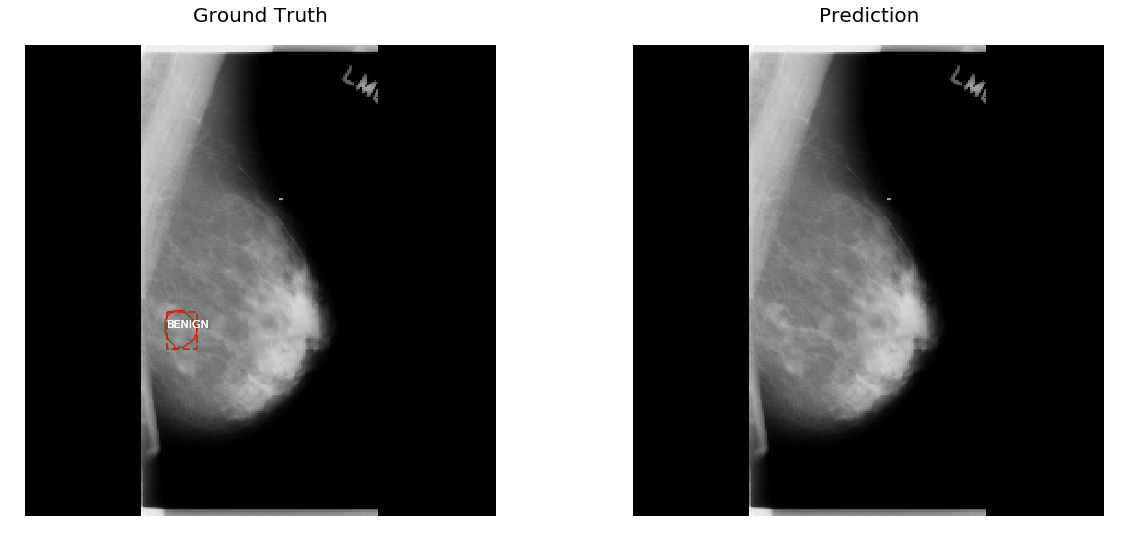

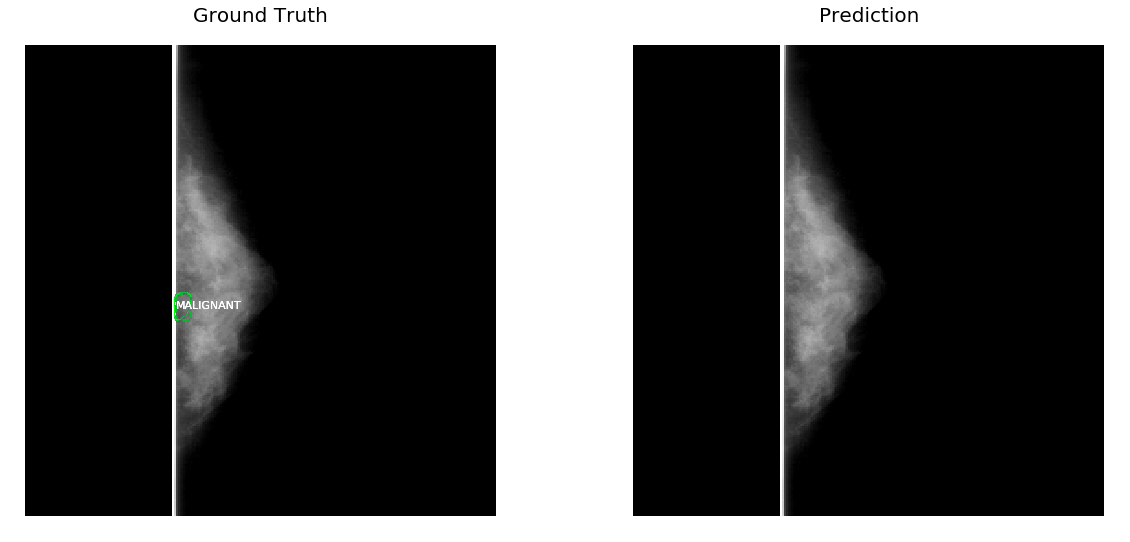

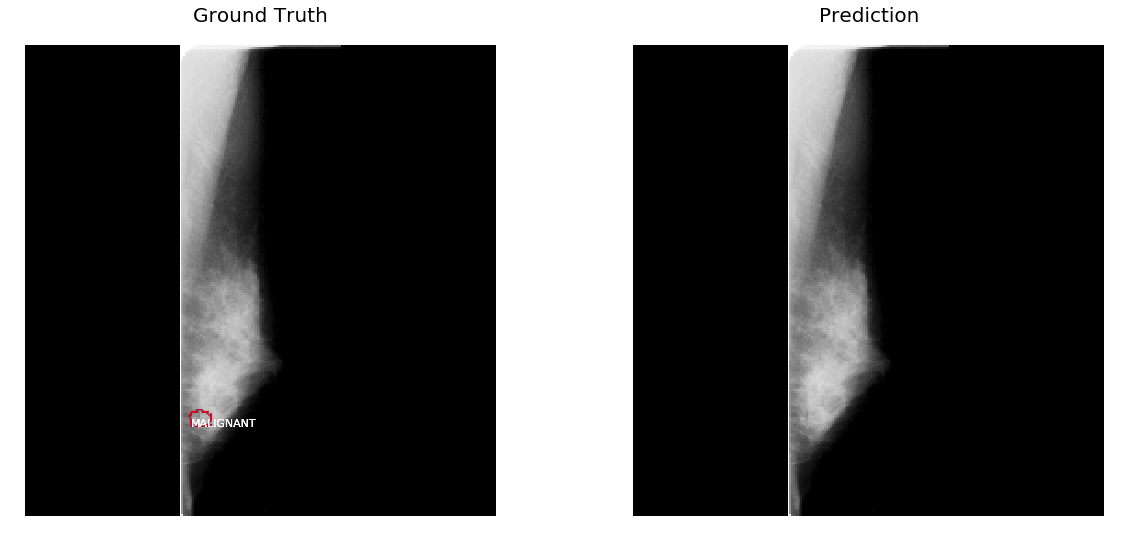

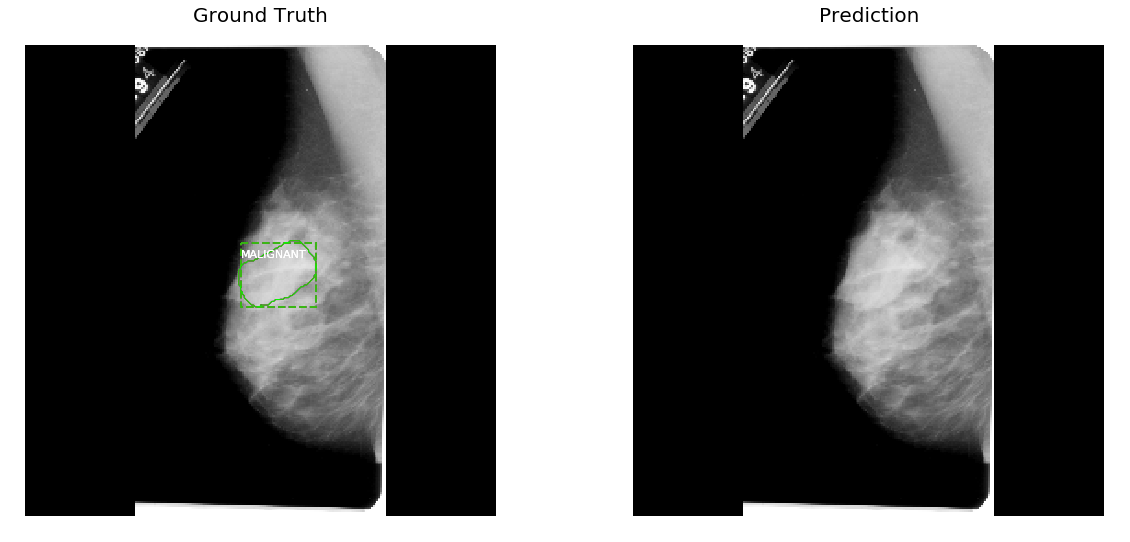

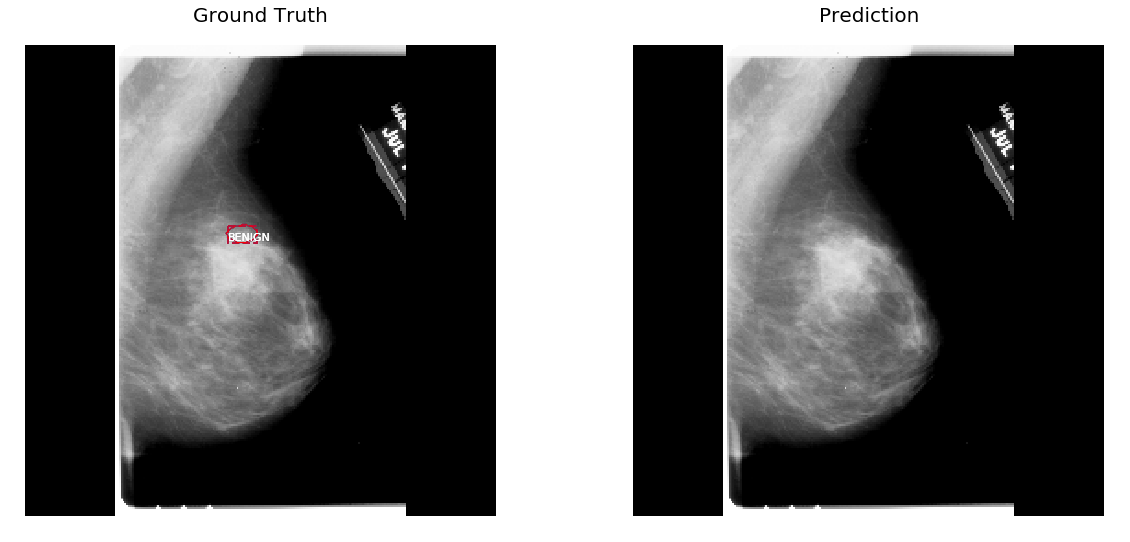

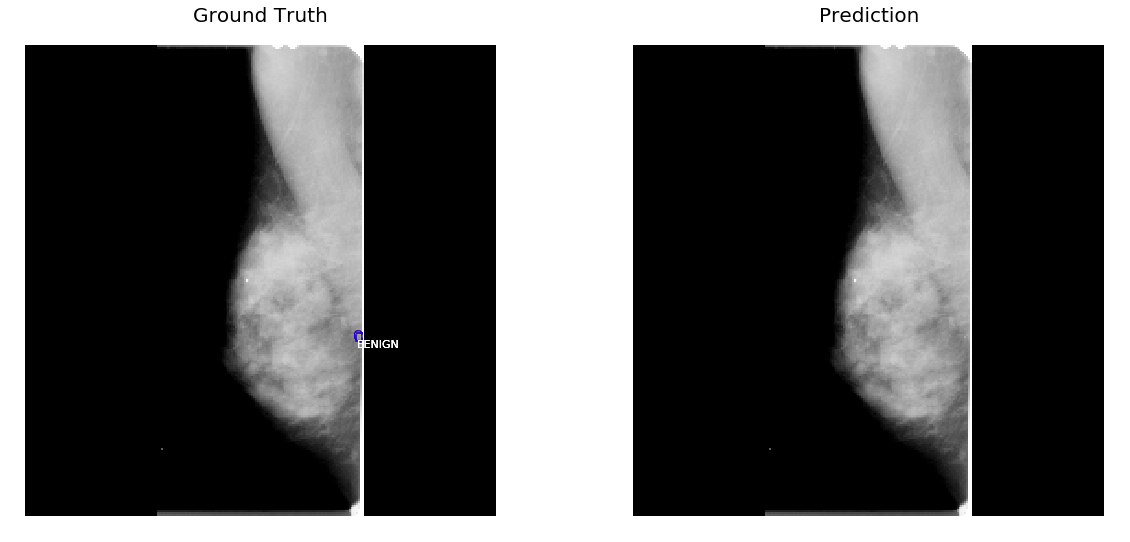

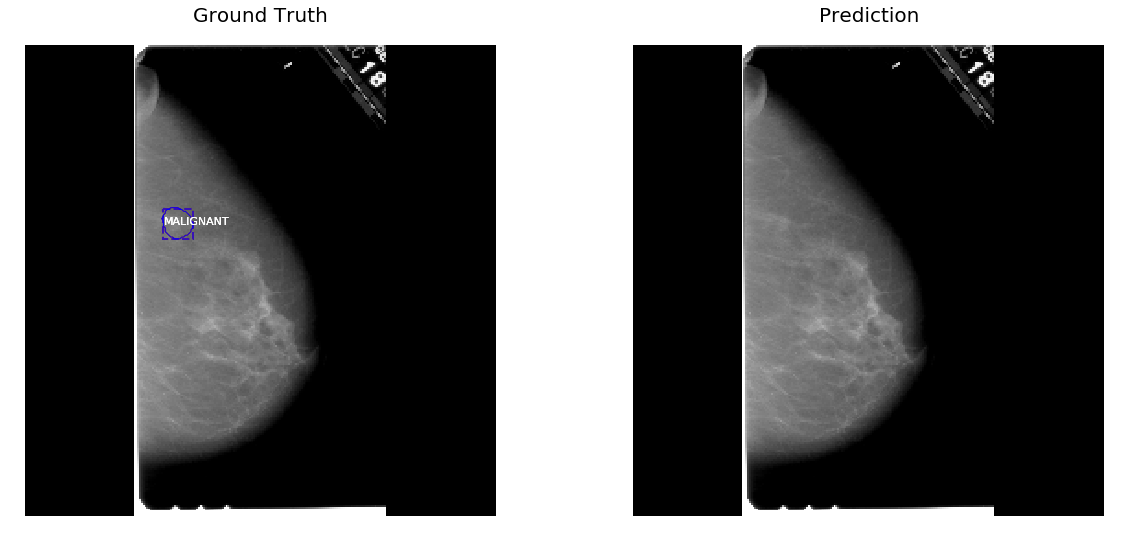

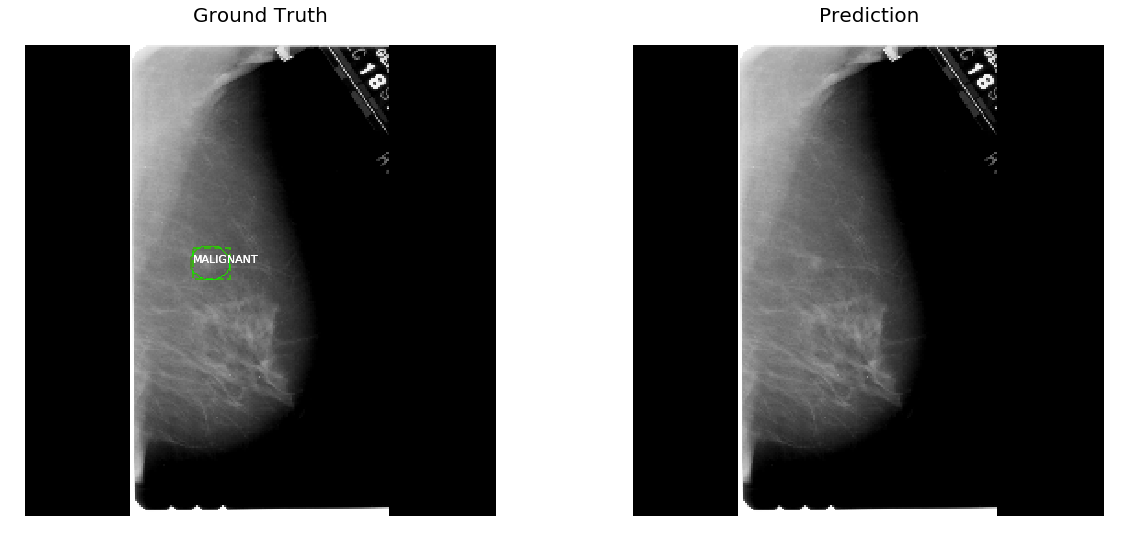

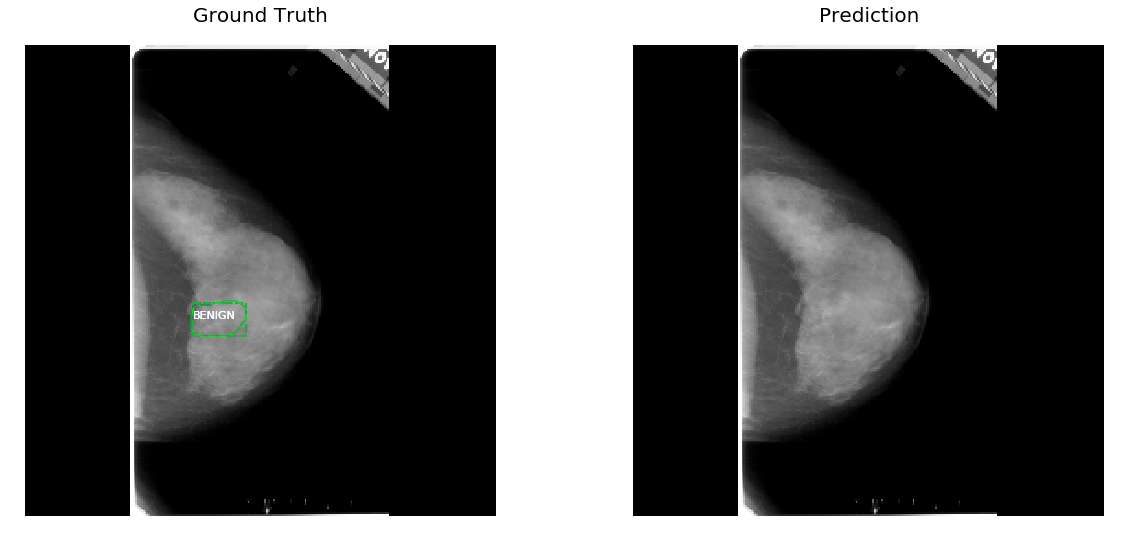

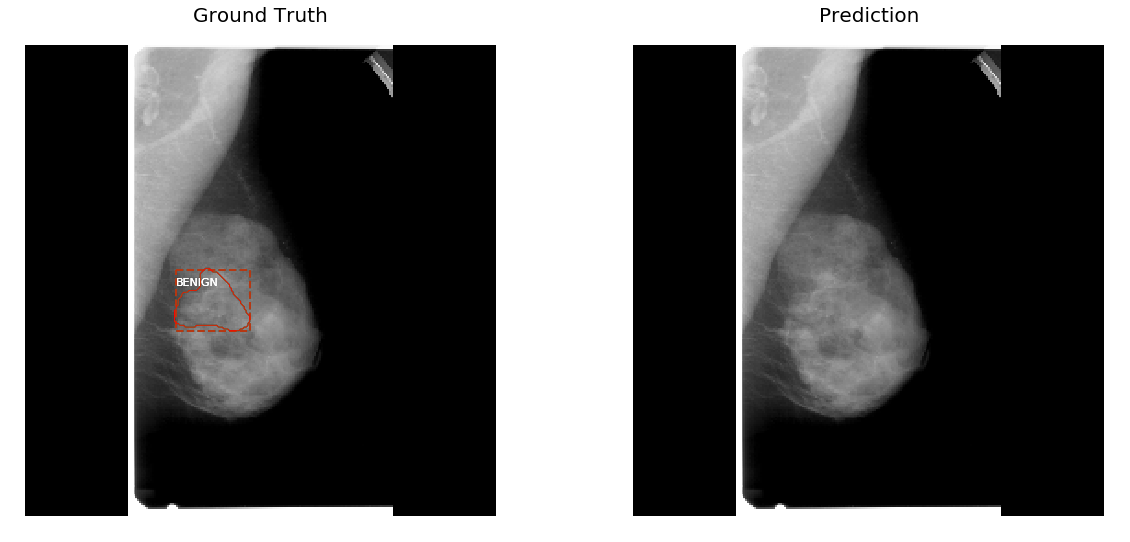

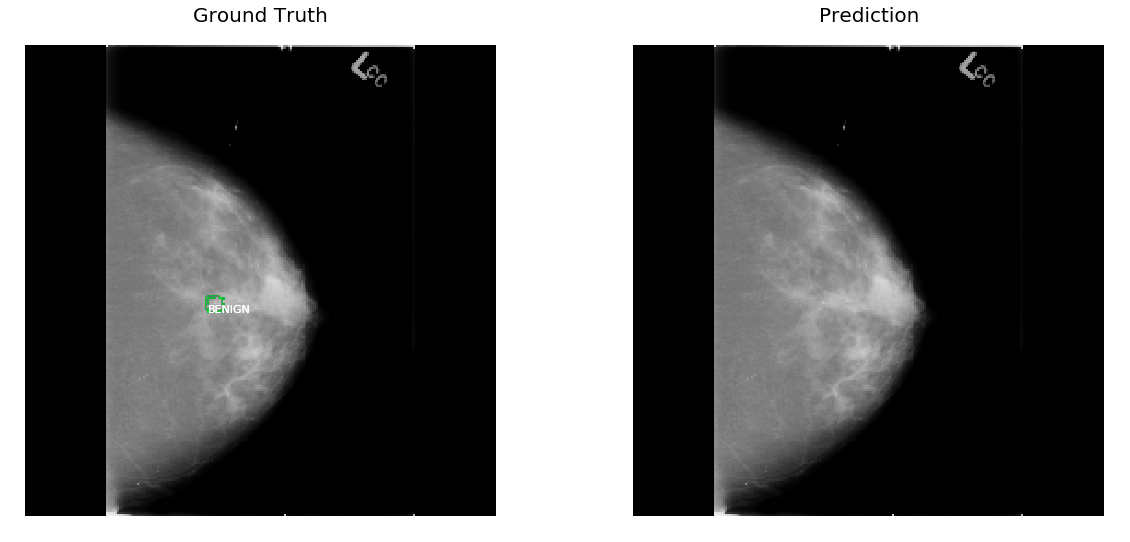

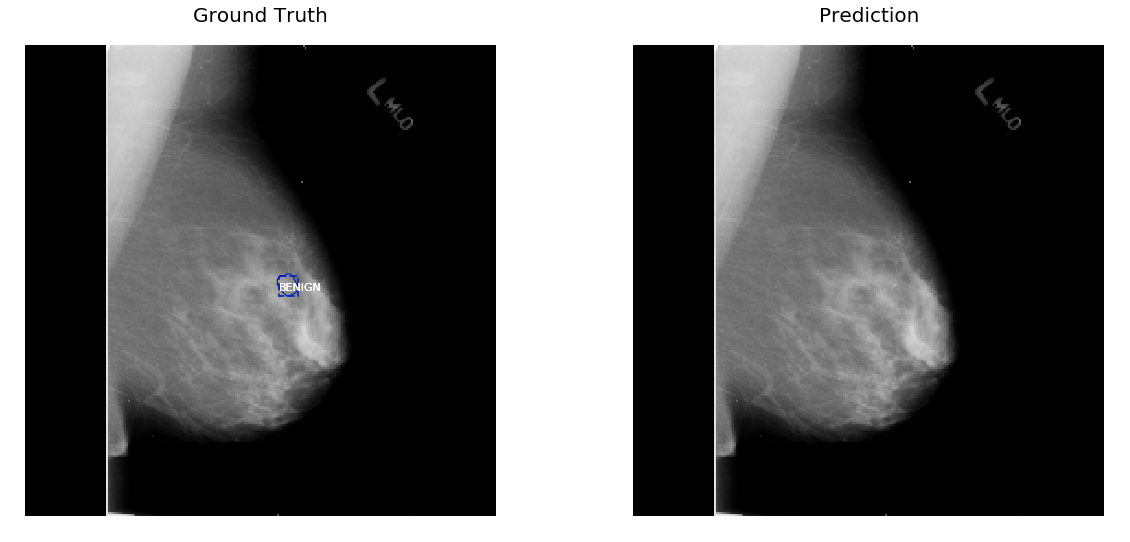

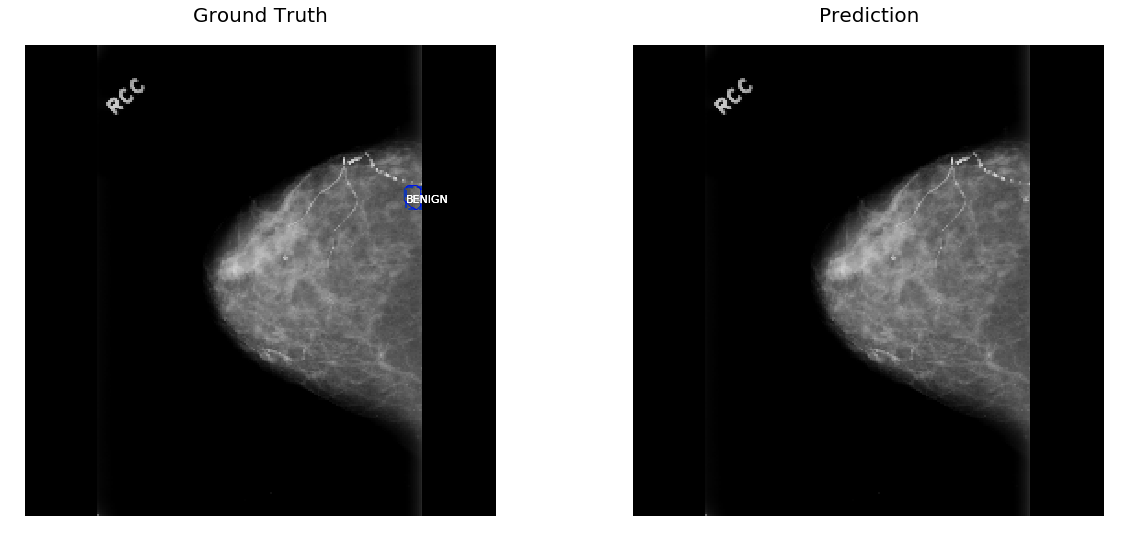

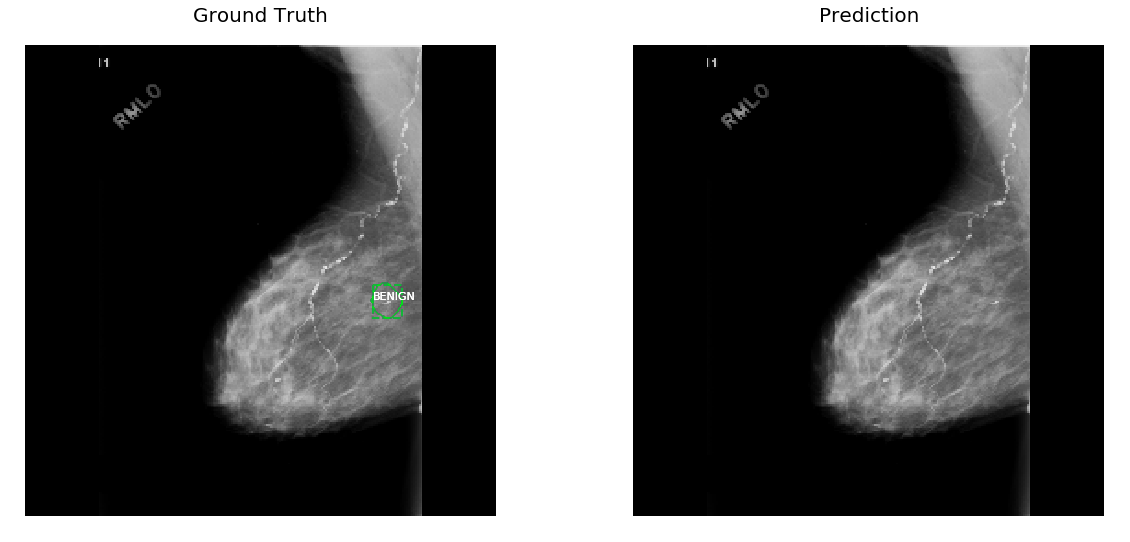

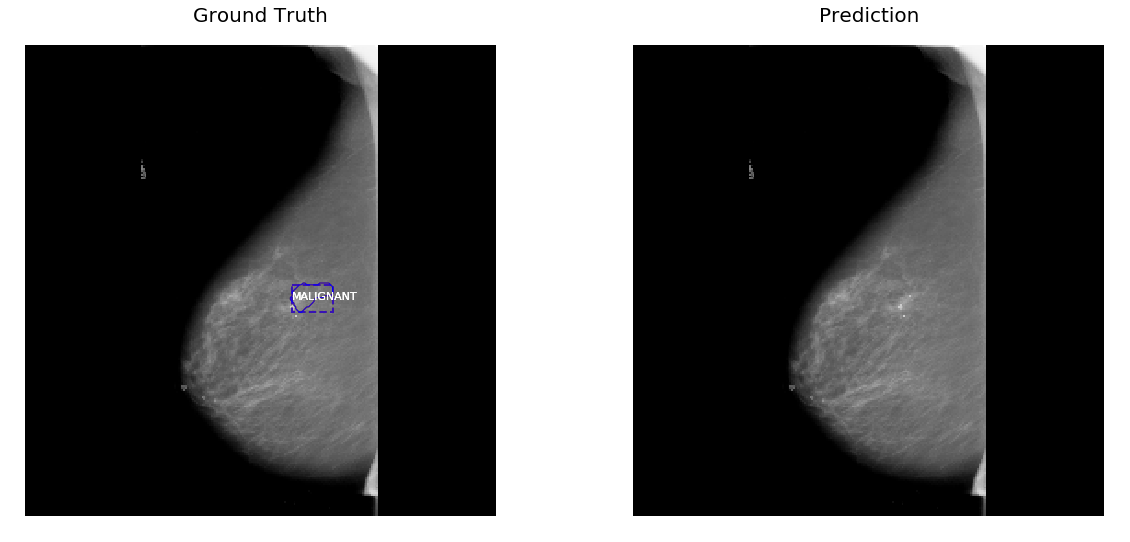

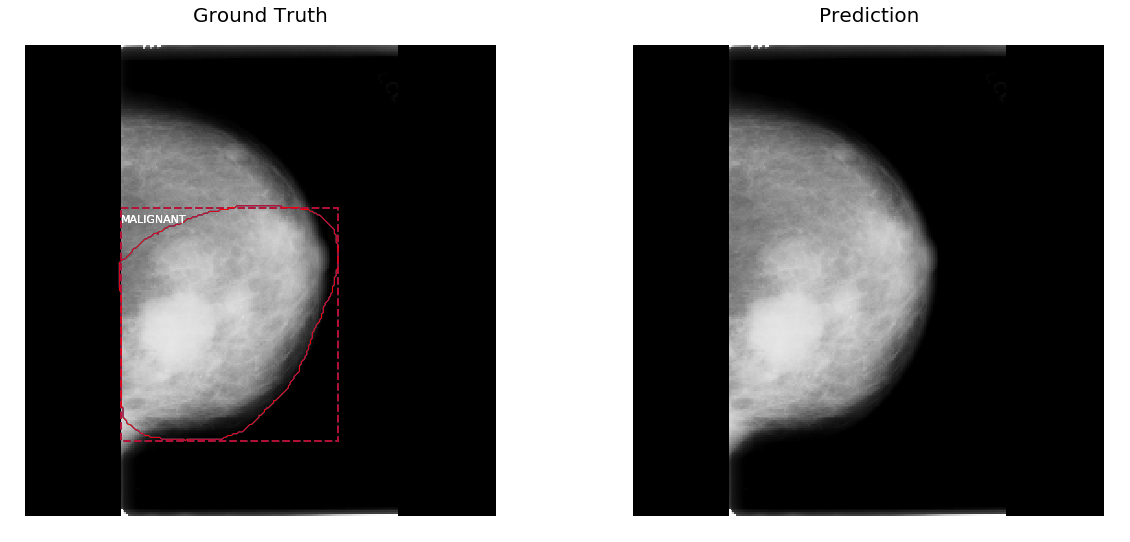

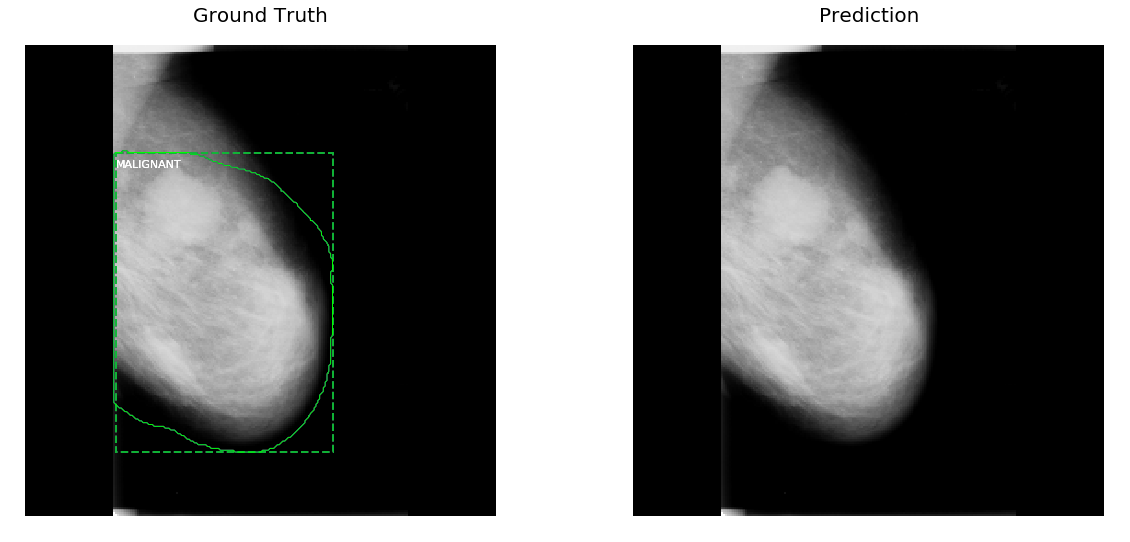

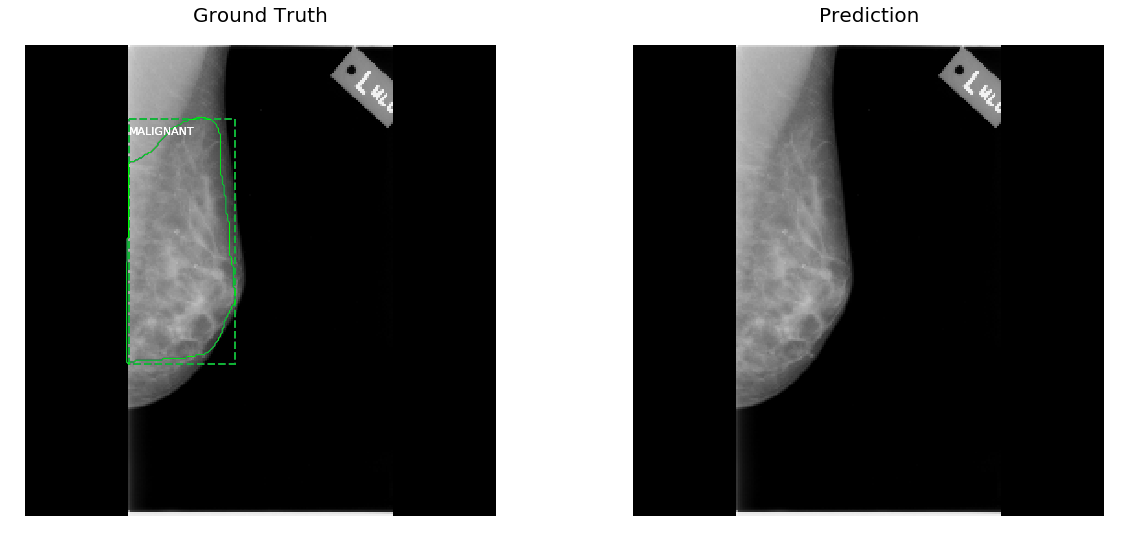

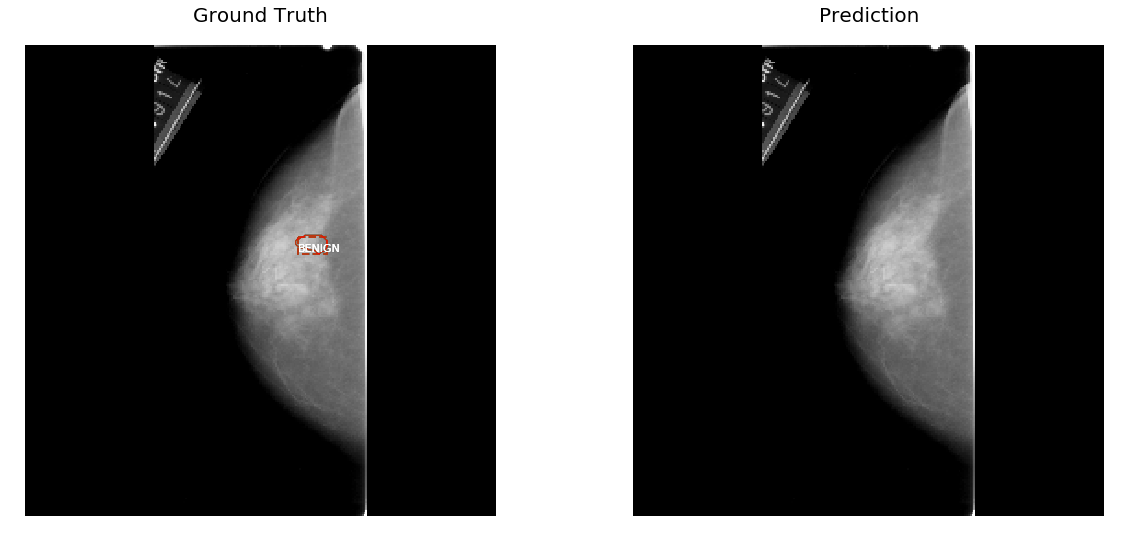

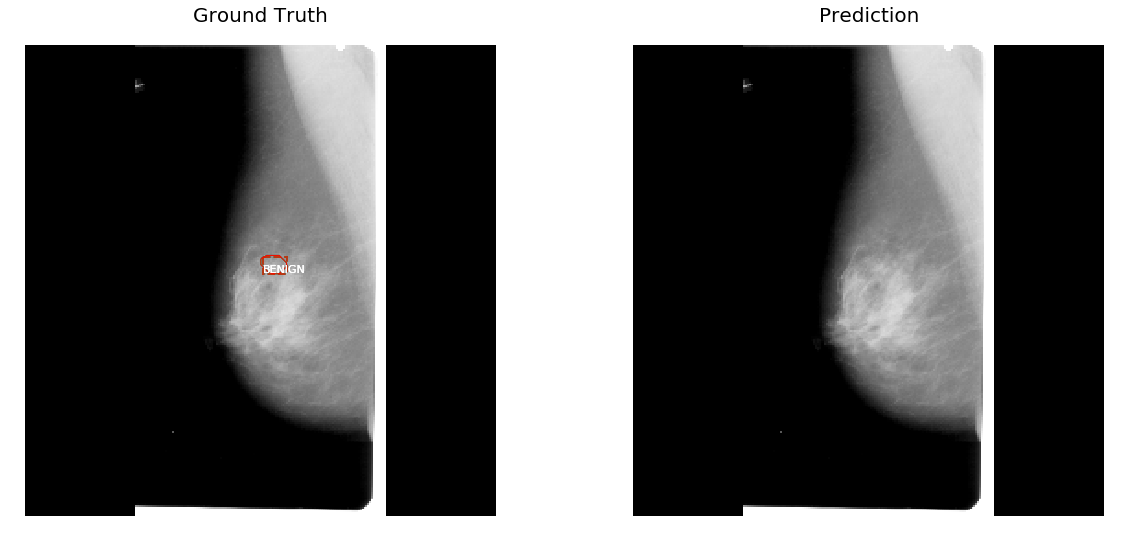

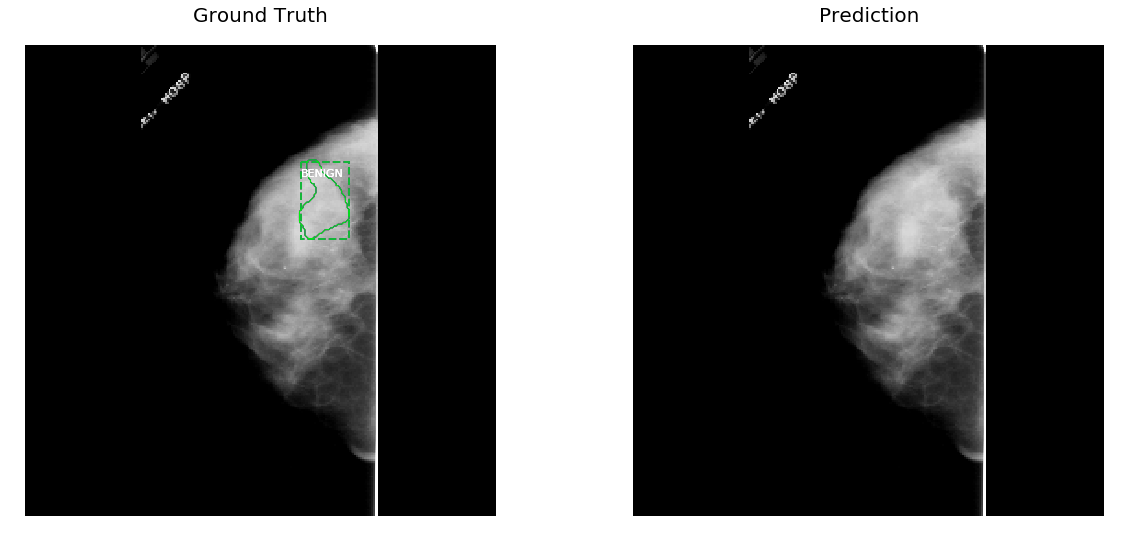

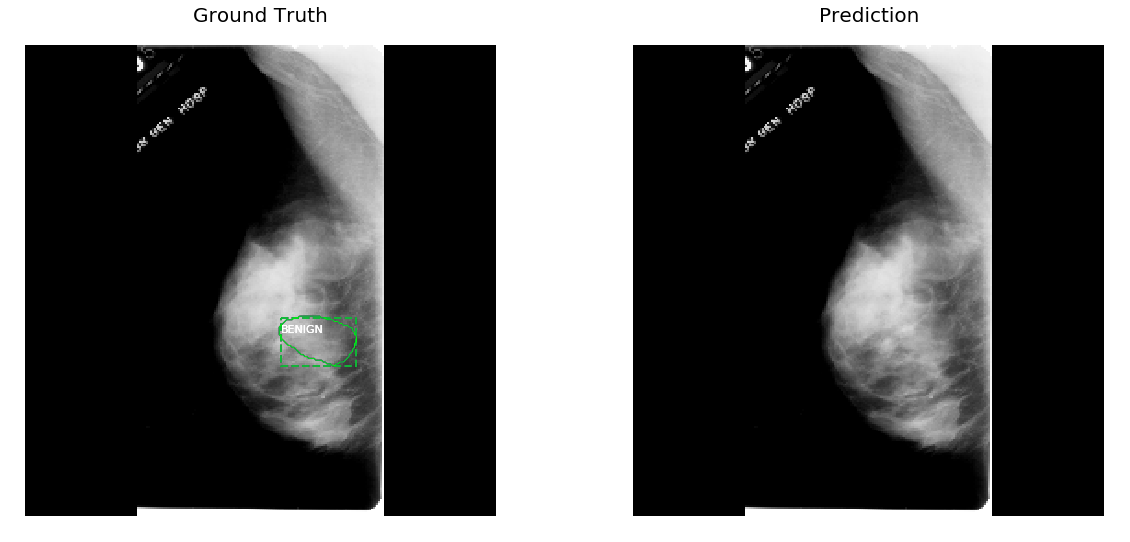

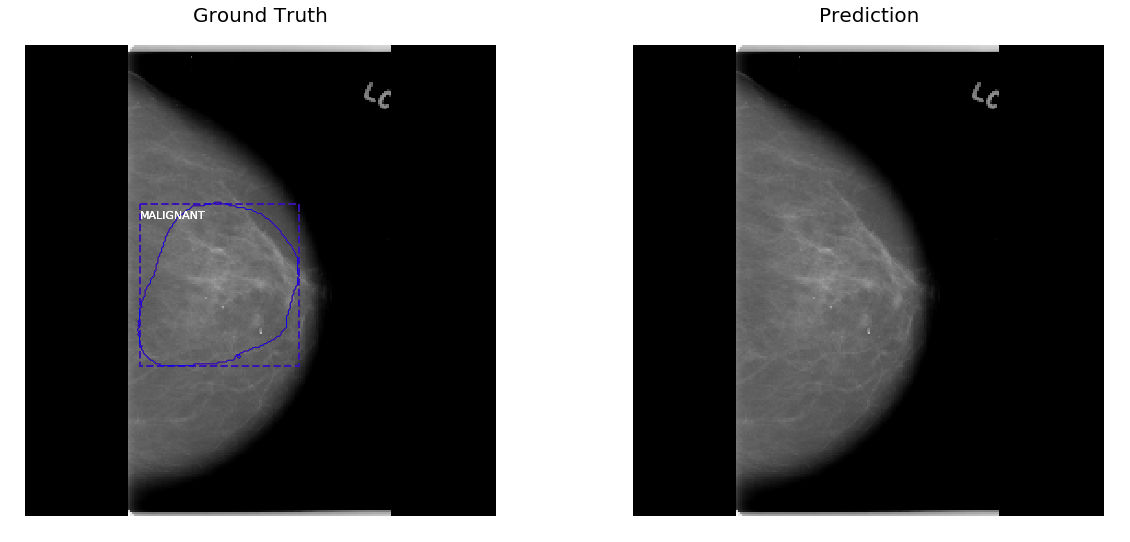

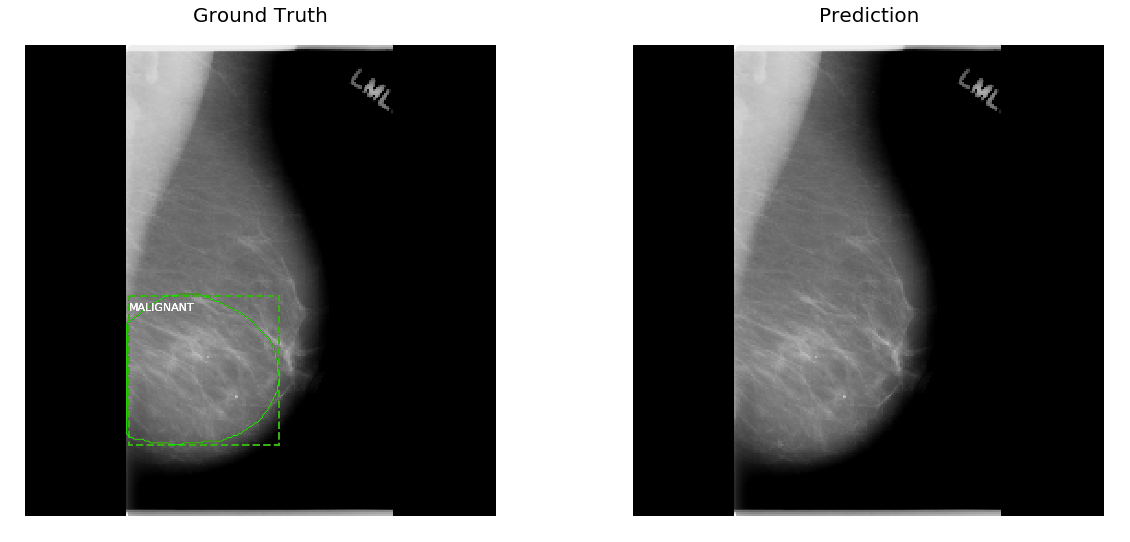

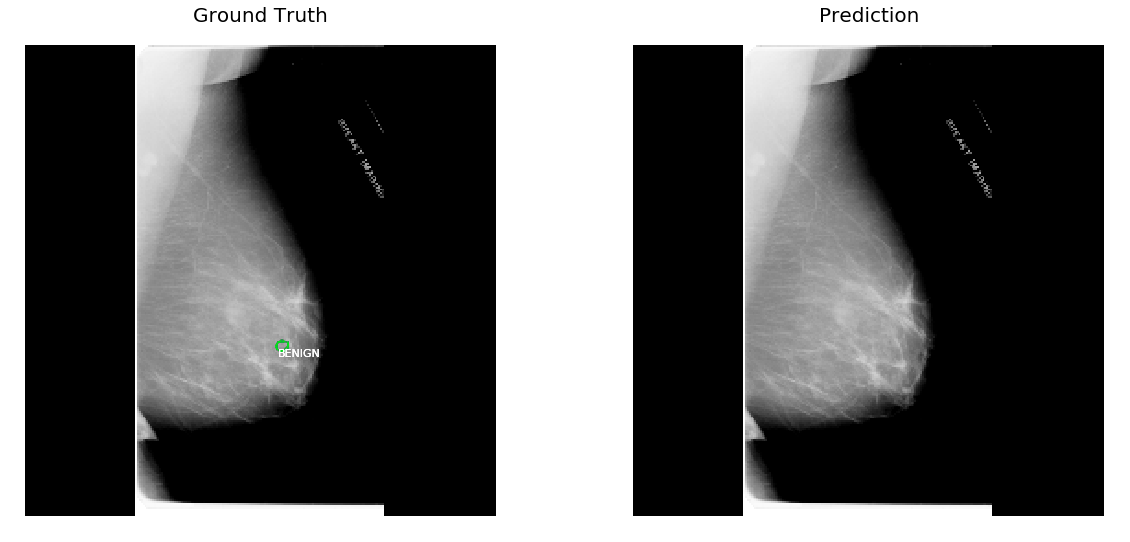

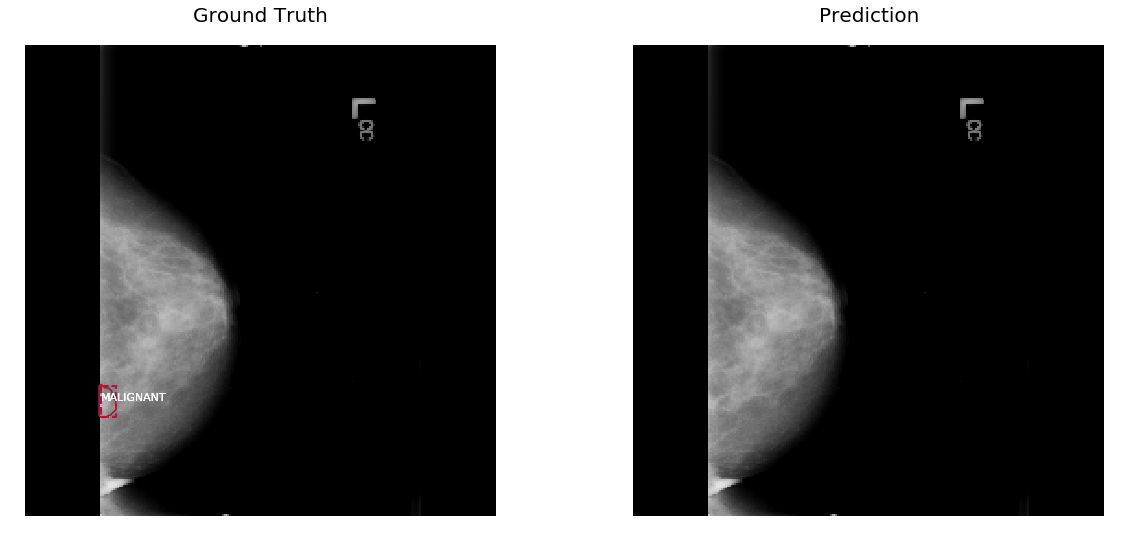

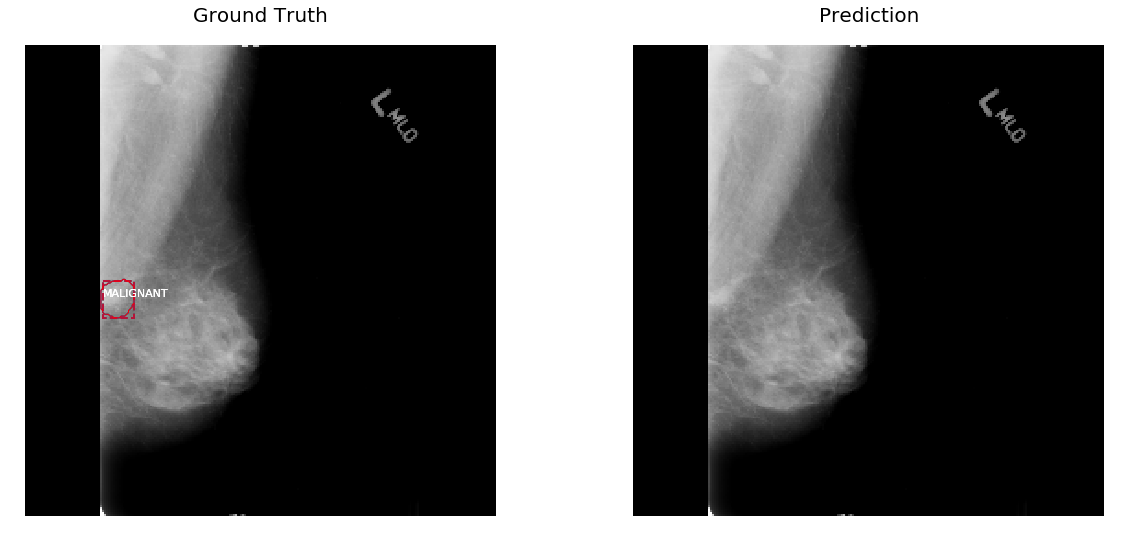

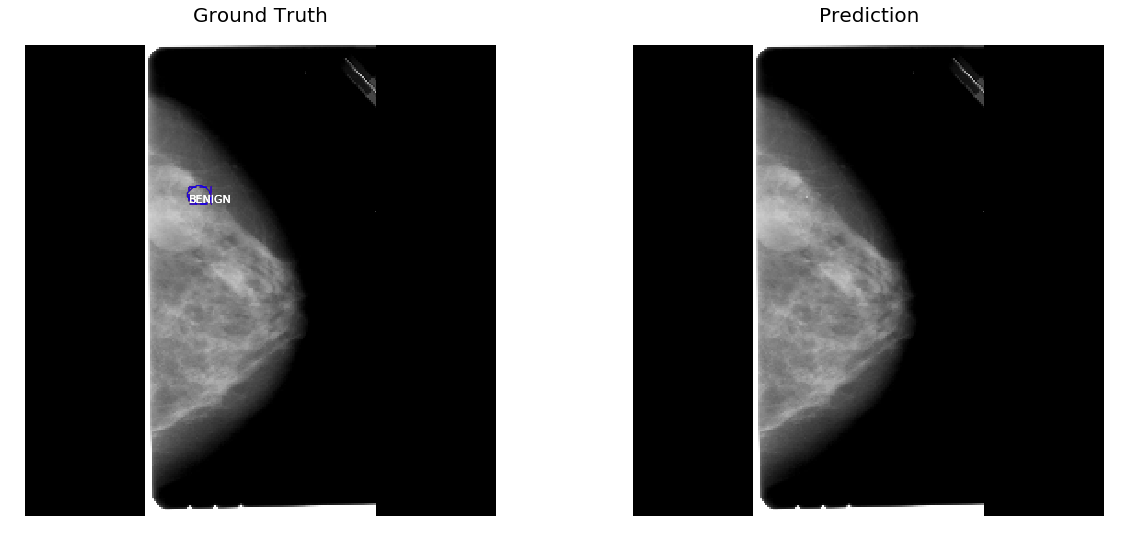

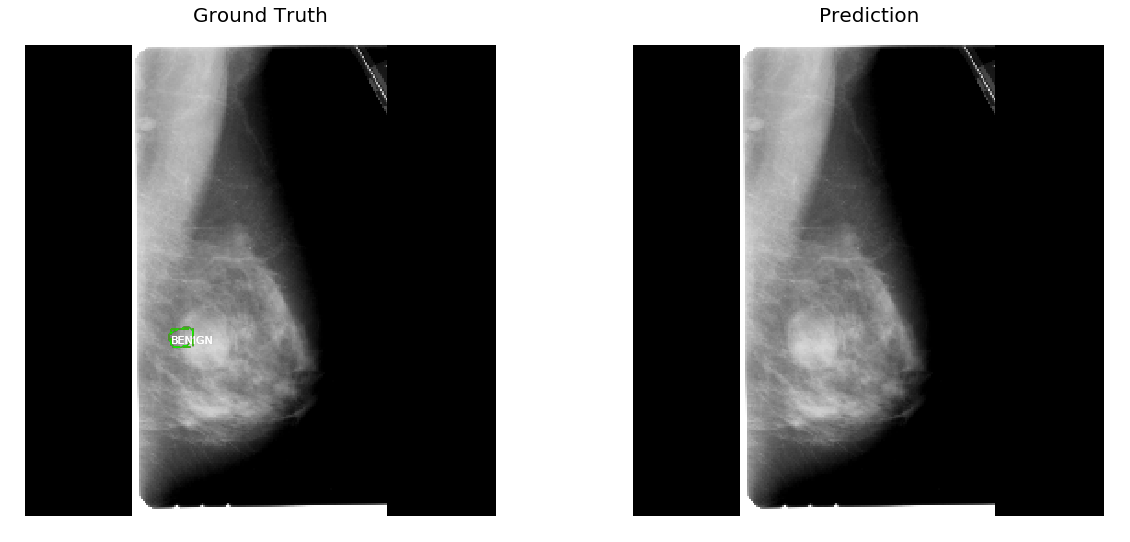

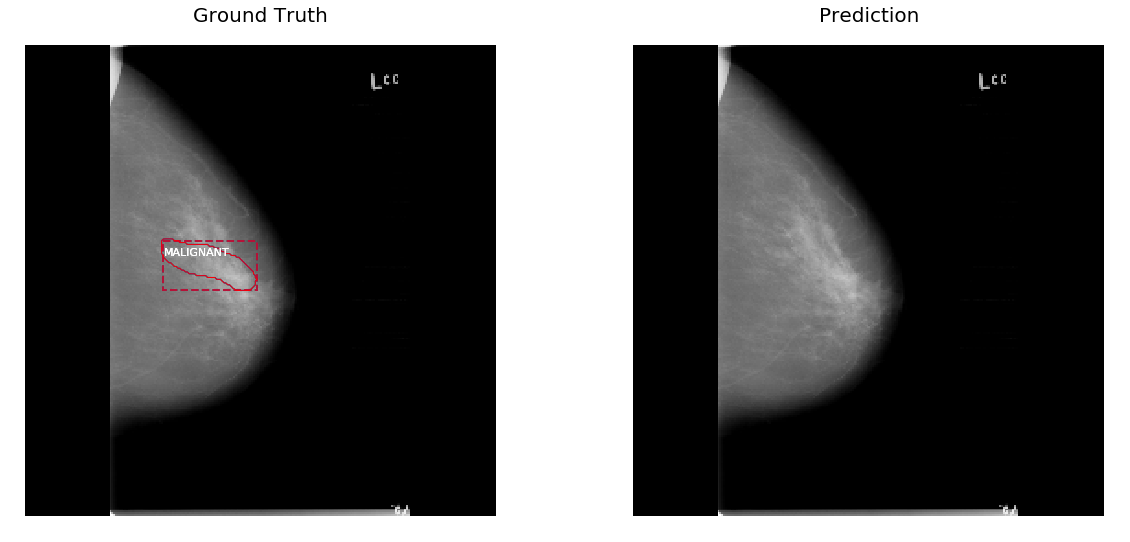

In [71]:
# Test on a random image
#image_id = random.choice(dataset_val.image_ids)
for i in range(0,50):
    j = 100
    image_id = j+i
    print('Image id: {0}'.format(image_id))
    original_image, image_meta, class_ids, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

    #log("original_image", original_image)
    #log("image_meta", image_meta)
    #log("gt_bbox", gt_bbox)
    #log("gt_mask", gt_mask)

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,20))

    visualize.display_instances(image = original_image,boxes = gt_bbox[:,:4],masks = gt_mask,class_ids = class_ids, 
                                class_names = dataset_val.class_names, figsize=(10, 10),ax=ax1)


    print()
    start =  time.time()
    results = model.detect([original_image], verbose=1)
    end = time.time()

    r = results[0]
    #print(r)
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=ax2)

    ax1.set_title('Ground Truth', fontsize=20)
    ax2.set_title('Prediction',fontsize=20)

    fig.subplots_adjust(hspace=50)

    print('Detection time = {0} seconds'.format(end-start))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.35494  max:    1.10396  float32

*** No instances to display *** 



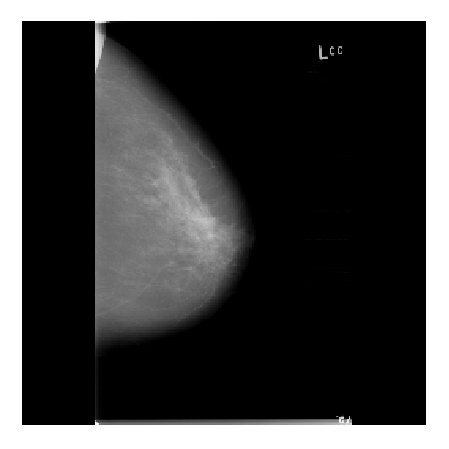

In [72]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [74]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 1000)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.0
